# Verkefni 1

Davíð Helgason  (dah38@hi.is)

Hieu

Hreiðar

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage # notum þetta fyrir myndir

import datetime # Notað til að mæla tímamismun.
import kmeans # Staðbundin skrá, fyrir k-means
import math # Stærðfræði
import glob # Notað til að finna skrár.

# Allt draslið er hér!
from prog import *

Hugtök
* centroid = þungamiðja, þyngdarpunktur, miðpunktur
* label = merki

Gögnin

In [2]:
# Hafðu True ef þú vilt búa til ný gögn, annars False
GENERATE_DATA = False

## Fyrri hluti

Gögnin

In [3]:
albums = [load_image_as_arr(path) for path in glob.glob('albums/*.jpg')]

In [4]:
# Búa til gögn
if GENERATE_DATA:
    generate_data_part1(albums, "bundles/")

In [5]:

bundles_album = []
for i in range(len(albums)):
    bundles_album += [get_best_bundle(glob.glob('bundles/bundle-*.npy'), str(i), do_filter=True)]

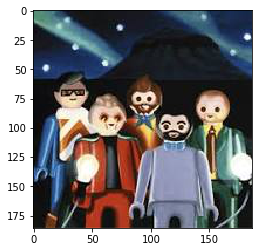

Final loss: 1150.07381


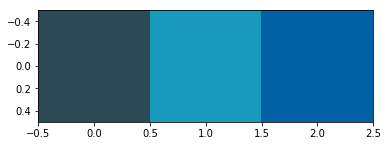

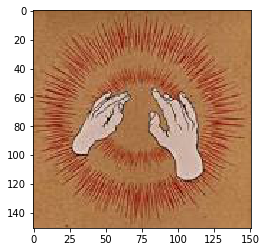

Final loss: 473.534177259


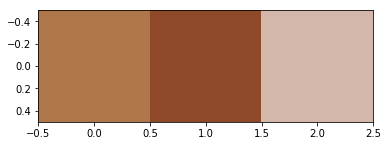

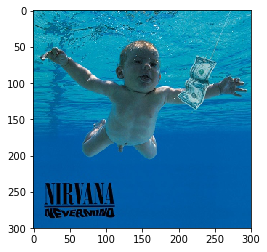

Final loss: 1184.00479062


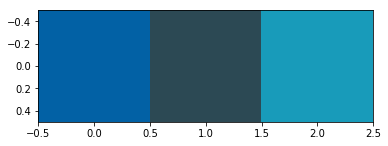

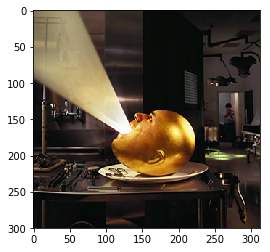

Final loss: 399.12551356


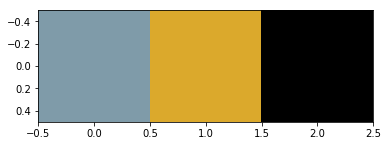

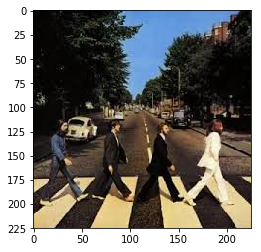

Final loss: 1466.03048325


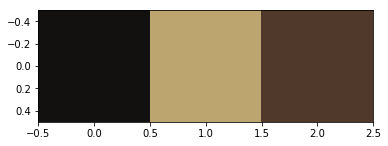

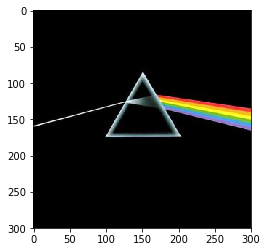

Final loss: 412.105229454


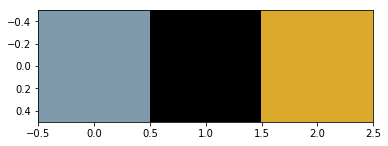

In [6]:
if True:
    for i, album in enumerate(albums):
        centroids = bundles_album[i]['centroids']
        display_arr(album)
        print("Final loss:", bundles_album[i]['losses'][-1])
        display_arr(np.array([centroids]))

## Seinni hluti

Verkferli

* (valfrjálst) skiptum inntakinu í 2 hluti, 90% til þjálfunar og 10% til að prófa
* Gera myndirnar (fylkið) tilbúnnar fyrir k-means
    * Fáum shape = (N, 28, 28) þar sem N er fjöldi mynda, viljum fá shape = (784, N)
    * Hver mynd verður að 784-vigri (28 x 28 = 784)
    * Notum:
        * reshape
        * transpose
        * etc..
* Þegar myndirnar eru orðnar tilbúnnar keyrum við k-means fyrir
    * k = 10, k = 20 og k = 30
* Fáum centroid fylki sem er shape (784, k)
* Breytum fulltrúunum (centroids) aftur í myndir, fáum k myndir, eina fyrir hvern fulltrúa.
* Þurfum að finna út hvaða merki (e. labels) hver þungamiðjupunktur (e. centroid) er fulltrúi fyrir.
    * Skoða hvaða myndir tilheyra þyrpingunni.
    * Mæla fjarlægðir milli hvers vigurs og þungamiðjupunkts og þannig gefa því merki samkvæmt því.
* Nota fulltrúanna til að greina myndirnar í test menginu og mæla villu í prósentum.
* Randome-a röðun á myndum?

In [7]:
A_images = np.load("mnist/A_images.npy")
A_labels = np.load("mnist/A_labels.npy")

B_images = np.load("mnist/B_images.npy")
B_labels = np.load("mnist/B_labels.npy")

In [8]:
# Búa til gögn
if GENERATE_DATA:
    generate_data_part2(A_images, "bundles/")

In [9]:
bundle10 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "10", do_filter=True)
bundle20 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "20", do_filter=True)
bundle30 = get_best_bundle(glob.glob('bundles/bundle-*.npy'), "30", do_filter=True)


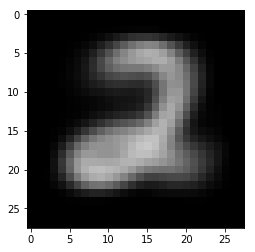

Centroid 1 / 10 is
   2  with a prob. of 91 %
   3  with a prob. of 3 %
   6  with a prob. of 1 %



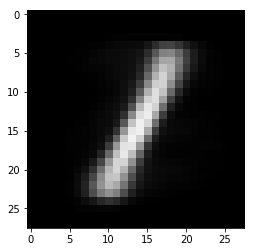

Centroid 2 / 10 is
   1  with a prob. of 77 %
   2  with a prob. of 7 %
   7  with a prob. of 5 %



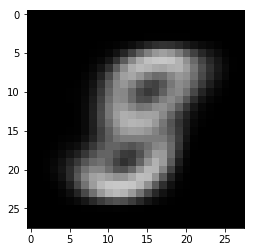

Centroid 3 / 10 is
   8  with a prob. of 43 %
   5  with a prob. of 22 %
   3  with a prob. of 21 %



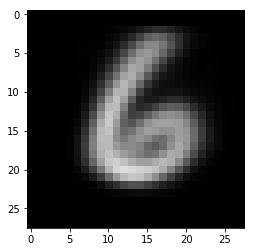

Centroid 4 / 10 is
   6  with a prob. of 85 %
   0  with a prob. of 4 %
   2  with a prob. of 2 %



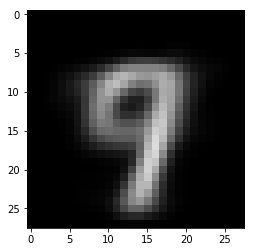

Centroid 5 / 10 is
   7  with a prob. of 36 %
   9  with a prob. of 32 %
   4  with a prob. of 21 %



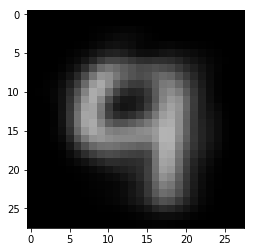

Centroid 6 / 10 is
   4  with a prob. of 40 %
   9  with a prob. of 25 %
   7  with a prob. of 11 %



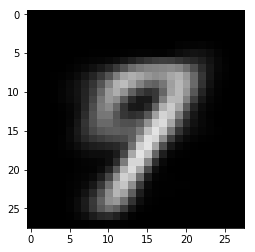

Centroid 7 / 10 is
   7  with a prob. of 41 %
   9  with a prob. of 27 %
   4  with a prob. of 24 %



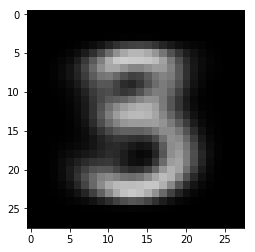

Centroid 8 / 10 is
   3  with a prob. of 51 %
   5  with a prob. of 19 %
   8  with a prob. of 17 %



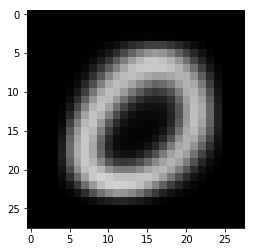

Centroid 9 / 10 is
   0  with a prob. of 94 %
   6  with a prob. of 1 %
   5  with a prob. of 1 %



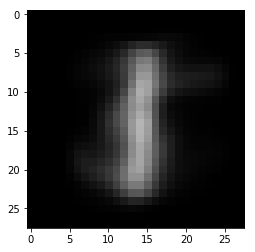

Centroid 10 / 10 is
   1  with a prob. of 41 %
   5  with a prob. of 17 %
   2  with a prob. of 9 %

--- --- --- ---


In [10]:
if True:
    test_bundle(bundle10, A_images, A_labels)

In [11]:
if False:
    test_bundle(bundle20, A_images, A_labels)

In [12]:
if False:
    test_bundle(bundle30, A_images, A_labels)

In [13]:
# Plot number of iterations and total loss (error) at each point
#plt.plot(range(0, len(losses)), losses)


In [14]:


def testzzz(idx, bundle, images, labels):
    classifier = classifier_factory(A_images, A_labels, bundle['centroids'], bundle['labels'], bundle['losses'])
    label = int(labels[idx][0])
    display_arr(images[idx])
    print("Actual:", label)
    digit = classifier(images[idx], display_best=True, breakdown=True)
    print("Got:", digit)


In [15]:
testzzz(0, bundle10, B_images, B_labels)


NameError: name 'classifier_factory' is not defined

In [ ]:


def testzq(bundle, images, labels):
    classifier = classifier_factory(A_images, A_labels, bundle['centroids'], bundle['labels'], bundle['losses'])
    N = len(images)
    N_correct = 0
    N_incorrect = 0
    list_correct = []
    list_incorrect = []
    
    for i in range(N):
        label = int(labels[i][0])
        digit = classifier(images[i])
        if digit == label:
            N_correct += 1
            list_correct += [i]
        else:
            N_incorrect += 1
            list_incorrect += [i]
        #print("Classified digit:", digit)
        #print("Actual digit:", b_label)
    print("Nr. of corrects:", N_correct)
    print("Nr. of incorrects:", N_incorrect)
    print("% correct:", int(100 * (N_correct / N)), "%")
    print("% error:", int(100 * (N_incorrect / N)), "%")
    
    return (list_correct, list_incorrect)

In [ ]:
print("k = 10")
lc10 = testzq(bundle10, B_images, B_labels)
print()
print("k = 20")
lc20 = testzq(bundle20, B_images, B_labels)
print()
print("k = 30")
lc30 = testzq(bundle30, B_images, B_labels)


In [ ]:
print("k = 10")
lc10 = testzq(bundle10, B_images, B_labels)
print()
print("k = 20")
lc20 = testzq(bundle20, B_images, B_labels)
print()
print("k = 30")
lc30 = testzq(bundle30, B_images, B_labels)


In [ ]:
zidx = 6
testzzz(lc10[1][zidx], bundle10, B_images, B_labels)